In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit, minimize
import os
from inspect import signature

def count_decays(df):
    decay_count = (df.iloc[:,0] < 40000).sum()
    return decay_count
    
data_dir = "data"
dataframes = []

for filename in os.listdir(data_dir):
    if filename.endswith(".data"):
        df = pd.read_csv(os.path.join(data_dir, filename), header=None, names=["tick","timestamp"], sep=" ")
        dataframes.append(df)
        df["timestamp"] = df["timestamp"] - df["timestamp"].iloc[0]
        
optimal_df = dataframes[0]
lower_df = dataframes[1]
higher_df = dataframes[2]
long_df = dataframes[3]

In [2]:
print(f"Optimal: {count_decays(optimal_df)} muon decays in {optimal_df.iloc[-1,1]} seconds.")
print(f"Lower: {count_decays(lower_df)} muon decays in {lower_df.iloc[-1,1]} seconds.")
print(f"Higher: {count_decays(higher_df)} muon decays in {higher_df.iloc[-1,1]} seconds.")
print(f"Long Run: {count_decays(long_df)} muon decays in {long_df.iloc[-1,1]} seconds.")

Optimal: 23 muon decays in 786 seconds.
Lower: 21 muon decays in 159 seconds.
Higher: 20 muon decays in 834 seconds.
Long Run: 3296 muon decays in 178519 seconds.


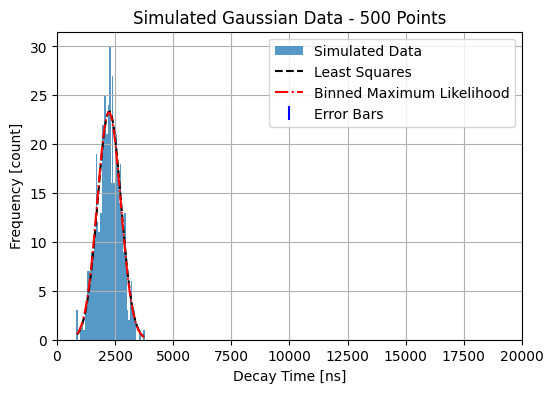

Least Squares Fit - parameters: [2253.71491514  501.84900226   23.36441493]
Least Squares Fit - covariance: [[ 5.12386210e+02 -5.68965947e-01  1.15848158e-02]
 [-5.68965947e-01  5.15306444e+02 -1.19866560e+01]
 [ 1.15848158e-02 -1.19866560e+01  8.33716099e-01]]
Least Squares Fit - param 1 error: 22.635949515827434
Least Squares Fit - param 2 error: 22.700362189895724
Binned Maximum Likelihood Fit - parameters: [2238.91437798  505.28655016   23.26260681]
Binned Maximum Likelihood Fit - covariance: [[ 1.65861092e-02 -2.89160845e-04  2.63683059e-06]
 [-2.89160845e-04  1.05777126e-02 -4.75506500e-04]
 [ 2.63683059e-06 -4.75506500e-04  5.37922055e-05]]
Binned Maximum Likelihood Fit - param 1 error: 0.12878706919643848
Binned Maximum Likelihood Fit - param 2 error: 0.10284800734859875


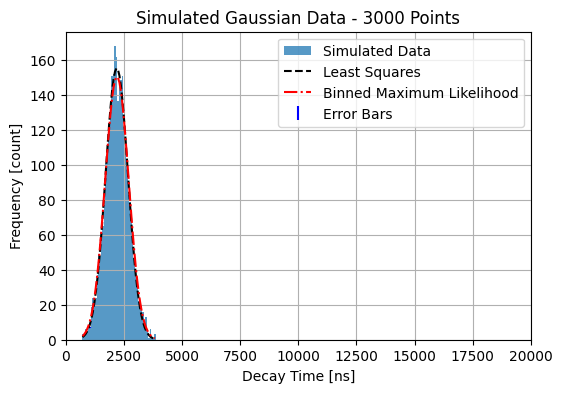

Least Squares Fit - parameters: [2193.91918477  482.9965431   155.52055805]
Least Squares Fit - covariance: [[ 5.35324465e+01 -1.56956988e-02  2.27487886e-03]
 [-1.56956988e-02  5.35909366e+01 -8.62688077e+00]
 [ 2.27487886e-03 -8.62688077e+00  4.16346159e+00]]
Least Squares Fit - param 1 error: 7.316587080652113
Least Squares Fit - param 2 error: 7.320583076331888
Binned Maximum Likelihood Fit - parameters: [2200.623713   505.482209   150.6888182]
Binned Maximum Likelihood Fit - covariance: [[ 1.01407210e-04  3.48144303e-05 -1.73361375e-05]
 [ 3.48144303e-05  9.13684682e-05 -5.42455696e-05]
 [-1.73361375e-05 -5.42455696e-05  4.61540448e-05]]
Binned Maximum Likelihood Fit - param 1 error: 0.010070114697009951
Binned Maximum Likelihood Fit - param 2 error: 0.0095586854827697


In [3]:
def simulate_gaussian_cdf(mu, sigma, num_points=1000):
    x_values = np.linspace(mu - 4 * sigma, mu + 4 * sigma, num_points)
    cdf_values = norm.cdf(x_values, mu, sigma)
    return x_values, cdf_values

def simulate_gaussian_data_from_cdf(cdf_values, x_values, num_points=1000):
    probs = np.random.rand(num_points)
    # Interpolate the inverse CDF function
    inv_cdf_func = np.interp(probs, cdf_values, x_values)
    return inv_cdf_func

def gaussian(x, mean, sigma, amplitude):
    return amplitude * np.exp(-((x - mean) / sigma) ** 2 / 2)

def log_likelihood(params, bin_centers, hist):
    mean, sigma, amplitude = params
    model = gaussian(bin_centers, mean, sigma, amplitude)
    log_likelihood = np.sum(hist * np.log(model) - model)
    return -log_likelihood

true_mean = 2200  # ns
true_sigma = 500   # ns

# Simulate the CDF for the Gaussian distribution
x_values, cdf_values = simulate_gaussian_cdf(true_mean, true_sigma)

simulated_counts = [500, 3000]

for count in simulated_counts:
    simulated_data = simulate_gaussian_data_from_cdf(cdf_values, x_values, num_points=count)

    # Plot histogram of simulated data with error bars
    plt.figure(figsize = (6,4))
    hist, bins, _ = plt.hist(simulated_data, bins=50, density=False, label='Simulated Data', alpha=0.75)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_width = bins[1] - bins[0]
    errors = np.sqrt(hist) / (count * bin_width)  # Standard error
    plt.errorbar(bin_centers, hist, yerr=errors, fmt='none', color='blue', label='Error Bars')
    plt.xlabel('Decay Time [ns]')
    plt.ylabel('Frequency [count]')
    plt.title(f'Simulated Gaussian Data - {count} Points')
    plt.xlim(0, 20000)
    plt.grid(True)

    # Fit Gaussian function to histogram using least squares
    popt, popc = curve_fit(gaussian, bin_centers, hist, p0=[true_mean, true_sigma, np.max(hist)])
    plt.plot(bin_centers, gaussian(bin_centers, *popt), color='k', linestyle = '--', label="Least Squares")

    nll = lambda *args: log_likelihood(*args)
    initial_params = [true_mean, true_sigma, np.max(hist)]
    result = minimize(nll, initial_params, args=(bin_centers, hist))
    bml_params = result.x
    
    hessian = result.hess_inv
    bml_covariance = hessian / (count * bin_width)
    
    plt.plot(bin_centers, gaussian(bin_centers, *bml_params), color='r', linestyle = '-.', label="Binned Maximum Likelihood")

    plt.legend()
    plt.show()

    print("Least Squares Fit - parameters:", popt)
    print("Least Squares Fit - covariance:", popc)
    
    print("Least Squares Fit - param 1 error:", np.sqrt(popc[0,0]))
    print("Least Squares Fit - param 2 error:", np.sqrt(popc[1,1]))
    
    print("Binned Maximum Likelihood Fit - parameters:", bml_params)
    print("Binned Maximum Likelihood Fit - covariance:", bml_covariance)
    
    print("Binned Maximum Likelihood Fit - param 1 error:", np.sqrt(bml_covariance[0,0]))
    print("Binned Maximum Likelihood Fit - param 2 error:", np.sqrt(bml_covariance[1,1]))   


Least Squares Fit - parameters: [15884.03555781  2080.95405985]
Least Squares Fit - covariance: [[35667.44133     4355.73860728]
 [ 4355.73860728   533.90042161]]
Least Squares Fit - param 1 error: 188.85825724600454
Least Squares Fit - param 2 error: 23.106285326868882
Binned Maximum Likelihood Fit - parameters: [14838.16536962  1918.42934202]
Binned Maximum Likelihood Fit - covariance: [[ 3.47327982 -2.79077225]
 [-2.79077225  2.24238027]]
Binned Maximum Likelihood Fit - param 1 error: 1.8636737433620416
Binned Maximum Likelihood Fit - param 2 error: 1.4974579349350814


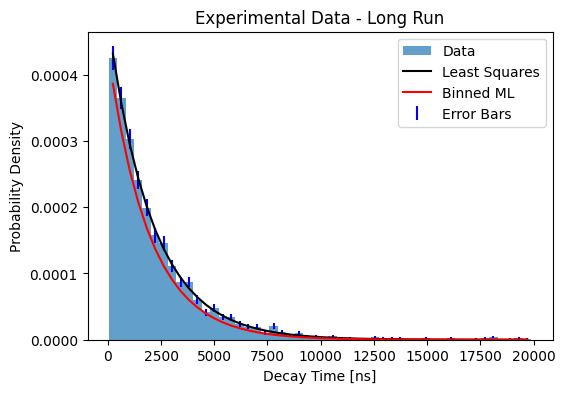

In [4]:
decays = long_df["tick"][long_df["tick"] < 40000]

def exponential_decay(x, mu, sigma):
    return np.exp(-x/sigma - mu/sigma)

hist, bins = np.histogram(decays, bins=50, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_width = bins[1] - bins[0]

# Least-squares fit
popt, pcov = curve_fit(exponential_decay, bin_centers, hist, p0=[np.mean(decays), np.std(decays)])

# Plot the histogram and the least-squares fit
plt.figure(figsize = (6,4))
plt.hist(decays, bins=bins, density=True, label='Data', alpha=0.7)
plt.errorbar(bin_centers, hist, yerr=np.sqrt(hist) / np.sqrt(len(decays) * bin_width), fmt='none', color='blue', label='Error Bars')
plt.plot(bin_centers, exponential_decay(bin_centers, *popt), color='k', label="Least Squares")
plt.xlabel('Decay Time [ns]')
plt.ylabel('Probability Density')
plt.title('Experimental Data - Long Run')
plt.legend()

print("Least Squares Fit - parameters:", popt)
print("Least Squares Fit - covariance:", pcov)
print("Least Squares Fit - param 1 error:", np.sqrt(pcov[0,0]))
print("Least Squares Fit - param 2 error:", np.sqrt(pcov[1,1]))


# Binned Maximum Likelihood fit
def log_likelihood(params, bin_centers, hist):
    mu, sigma = params
    model = exponential_decay(bin_centers, mu, sigma)
    log_likelihood = np.sum(hist * np.log(model) - model)
    return -log_likelihood

nll = lambda *args: log_likelihood(*args)
initial_params = [np.mean(decays), 12000]
result = minimize(nll, initial_params, args=(bin_centers, hist))
bml_params = result.x

# Calculate the covariance matrix
hessian = result.hess_inv
bml_covariance = hessian / (len(decays) * bin_width)

# Plot the Binned Maximum Likelihood fit
plt.plot(bin_centers, exponential_decay(bin_centers, *bml_params), color='r', label="Binned ML")

# Print the Binned Maximum Likelihood fit parameters and covariance
print("Binned Maximum Likelihood Fit - parameters:", bml_params)
print("Binned Maximum Likelihood Fit - covariance:", bml_covariance)
print("Binned Maximum Likelihood Fit - param 1 error:", np.sqrt(bml_covariance[0,0]))
print("Binned Maximum Likelihood Fit - param 2 error:", np.sqrt(bml_covariance[1,1]))

plt.legend()
plt.show()

Group 1:
Decay Time: 1916.1140636216478
Decay Time Error: 3.8478074224727825
Group 2:
Decay Time: 2165.6121274813077
Decay Time Error: 3.8973663636804132
Group 3:
Decay Time: 2168.2627318279665
Decay Time Error: 3.8752780546472176
Group 4:
Decay Time: 1955.9135450882577
Decay Time Error: 3.875677324891999
Group 5:
Decay Time: 2175.788085944837
Decay Time Error: 3.866177336535994
Group 6:
Decay Time: 1992.0579510785037
Decay Time Error: 3.86480017095431


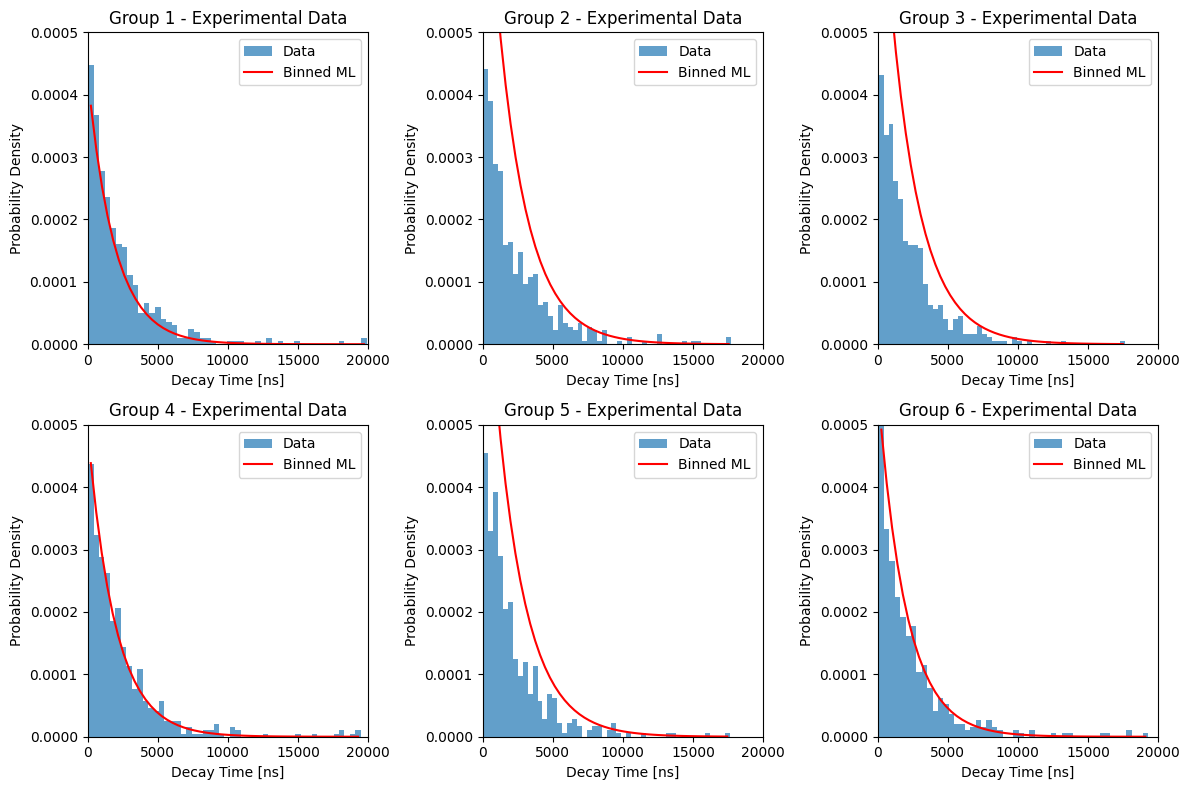

Average Lifetime: 2062.291417507087
Statistical Error: 1.5804161619618622


In [9]:
# Function for exponential decay
def exponential_decay(x, mu, sigma):
    return np.exp(-x / sigma - mu / sigma)

# Define function to calculate log likelihood
def log_likelihood(params, bin_centers, hist):
    mu, sigma = params
    model = exponential_decay(bin_centers, mu, sigma)
    log_likelihood = np.sum(hist * np.log(model) - model)
    return -log_likelihood

# Divide data into groups of 500 points
group_size = 500
num_groups = len(decays) // group_size

average_lifetimes = []
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()

for i in range(num_groups):
    group_data = decays[i * group_size: (i + 1) * group_size]
    hist, bins = np.histogram(group_data, bins=50, density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_width = bins[1] - bins[0]

    # Binned Maximum Likelihood fit
    initial_params = [np.mean(group_data), 12000]
    result = minimize(log_likelihood, initial_params, args=(bin_centers, hist))
    bml_params = result.x

    # Calculate covariance matrix
    hessian = result.hess_inv
    bml_covariance = hessian / (len(group_data) * bin_width)

    # Extract decay time and error
    decay_time = bml_params[1]
    decay_error = np.sqrt(bml_covariance[1, 1])
    
    average_lifetimes.append((decay_time, decay_error))

    # Plotting
    axs[i].hist(group_data, bins=bins, density=True, label='Data', alpha=0.7)
    axs[i].plot(bin_centers, exponential_decay(bin_centers, *bml_params), color='r', label="Binned ML")
    axs[i].set_xlabel('Decay Time [ns]')
    axs[i].set_ylabel('Probability Density')
    axs[i].set_title(f'Group {i+1} - Experimental Data')
    axs[i].set_xlim(0,20000)
    axs[i].set_ylim(0,0.0005)
    axs[i].legend()

    print(f"Group {i+1}:")
    print("Decay Time:", decay_time)
    print("Decay Time Error:", decay_error)

plt.tight_layout()
plt.show()

average_lifetime = np.mean([lifetime[0] for lifetime in average_lifetimes])
average_lifetime_error = np.sqrt(np.sum([lifetime[1] ** 2 for lifetime in average_lifetimes])) / num_groups
print("Average Lifetime:", average_lifetime)
print("Statistical Error:", average_lifetime_error)
